In [1]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from models import *
from utils import *
from datasets import *

In [2]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

# # sample
# idx = np.random.choice(np.arange(len(trainset)), size=1000)
# trainset = [trainset[i] for i in idx]
# idx = np.random.choice(np.arange(len(testset)), size=1000)
# testset = [testset[i] for i in idx]

traindata = [i[0].unsqueeze(0) for i in trainset]
trainlabel = [i[1] for i in trainset]
testdata = [i[0].unsqueeze(0) for i in testset]
testlabel = [i[1] for i in testset]

X_train = torch.vstack(traindata)
y_train = torch.tensor(trainlabel)
X_test = torch.vstack(testdata)
y_test = torch.tensor(testlabel)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [7]:
# number of trees in random projection forest
n_trees = 5 + int(round((X_train.shape[0]) ** 0.5 / 20.0))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(X_train.shape[0]))))

# get nearest neighbors
nnd = NNDescent(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    n_neighbors=1000,
    metric='euclidean',
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)

# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph

Thu Dec 28 18:22:18 2023 Building RP forest with 17 trees
Thu Dec 28 18:22:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	Stopping threshold met -- exiting after 7 iterations


In [9]:
knn_indices.shape, knn_indices[0].shape

((60000, 1000), (1000,))

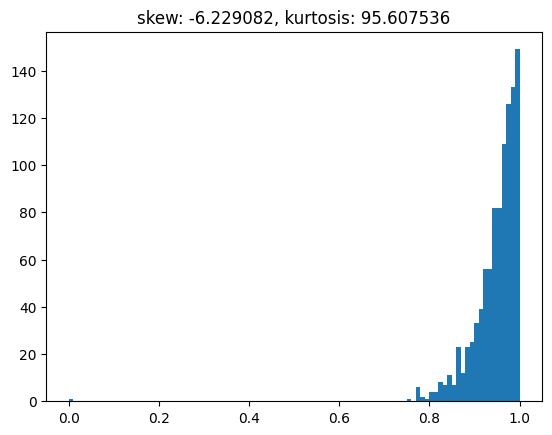

In [69]:
import scipy

i = 0
distrib = (knn_dists[i]-knn_dists[i].min())/(knn_dists[i].max()-knn_dists[i].min())
plt.hist(distrib, bins=100)
plt.title("skew: {:.6f}, kurtosis: {:.6f}".format(scipy.stats.skew(distrib), scipy.stats.kurtosis(distrib)))
plt.show()

In [71]:
skews, kurtosises = [], []

for i in tqdm(range(len(knn_dists))):
    distrib = (knn_dists[i]-knn_dists[i].min())/(knn_dists[i].max()-knn_dists[i].min())
    skews.append(scipy.stats.skew(distrib))
    kurtosises.append(scipy.stats.kurtosis(distrib))

np.mean(skews), np.std(skews), np.mean(kurtosises), np.std(kurtosises)

100%|██████████| 60000/60000 [00:32<00:00, 1864.59it/s]


(-3.3971994741707414,
 2.0821781522155183,
 36.498193554191715,
 44.54240353498941)

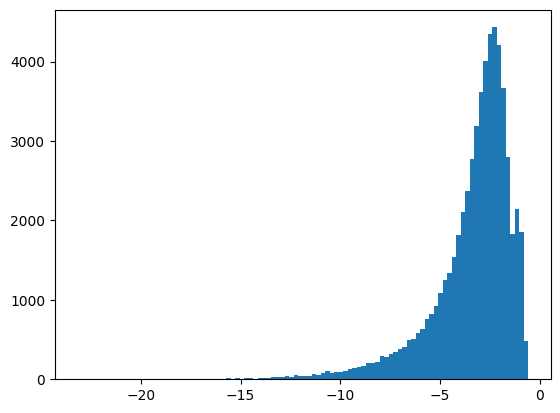

In [79]:
plt.hist(skews, bins=100)
plt.show()

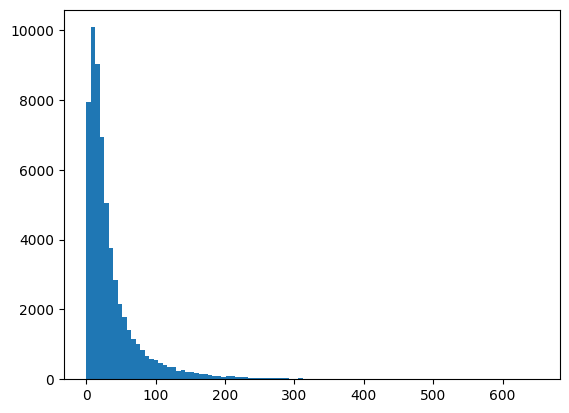

In [82]:
plt.hist(kurtosises, bins=100)
plt.show()

In [83]:
skews, kurtosises = [], []

for i in tqdm(range(len(knn_dists))):
    # distrib = (knn_dists[i]-knn_dists[i].min())/(knn_dists[i].max()-knn_dists[i].min())
    distrib = knn_dists[i]
    skews.append(scipy.stats.skew(distrib))
    kurtosises.append(scipy.stats.kurtosis(distrib))

np.mean(skews), np.std(skews), np.mean(kurtosises), np.std(kurtosises)

100%|██████████| 60000/60000 [00:37<00:00, 1590.37it/s]


(-3.3971994640330077, 2.082178146159326, 36.49819346443305, 44.54240355446985)

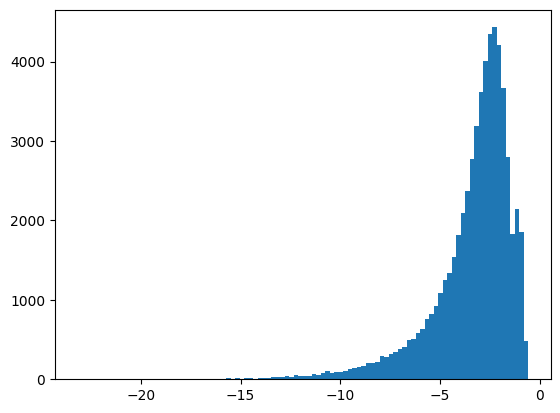

In [84]:
plt.hist(skews, bins=100)
plt.show()

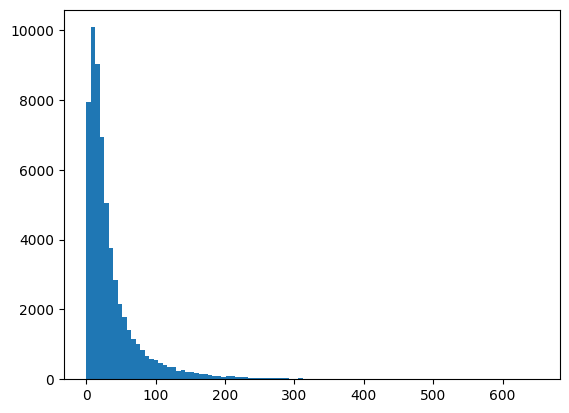

In [85]:
plt.hist(kurtosises, bins=100)
plt.show()